# Attention mechanism

어텐션 메커니즘은 시퀀스-투-시퀀스(seq2seq) 모델에서 입력 시퀀스의 중요한 부분에 집중할 수 있도록 돕는 기술이다. 

앞에서 살펴본 encoder-decoder 모형에 어텐션 메커니즘을 추가해 보자.

어텐션 메커니즘의 핵심 요소는 dot product로 구현된다.

먼저 numpy array로 어텐션 과정을 훑어보자.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2) 

# 길이 6의 인코더 출력 및 디코더 출력 생성
encoder_timesteps = 6
decoder_timesteps = 6

가상의 인코더 출력과 디코더 출력 시퀀스를 생각해 보자.

- 인코더 출력은 랜덤하게 구성되어 있다.

- 디코더 출력은 인코딩 출력을 한 타임스텝만큼 뒤로 이동시킨 후 약간의 노이즈를 추가하였다.

- 디코더 출력의 첫 번째 값은 다시 랜덤하게 설정.

In [15]:
latent_dim = 4

# 인코더 출력 (임의의 값)
encoder_outputs = np.random.normal(0, 1, size=(encoder_timesteps, latent_dim))  # shape : (encoder_timesteps, latent_dim)
# 디코더 출력 
decoder_outputs = np.roll(encoder_outputs, shift=1, axis=0)
decoder_outputs[0] = np.random.normal(0, 0.1, latent_dim)
decoder_outputs = decoder_outputs + np.random.normal(0, 0.01, decoder_outputs.shape)  # shape : (decoder_timesteps, latent_dim)

print(encoder_outputs[:, 0])
print(decoder_outputs[:, 0])

[-0.41675785 -1.79343559 -1.05795222  0.04153939 -0.0191305  -0.87810789]
[-0.04809437 -0.44110552 -1.78841701 -1.0610873   0.05621617 -0.02742185]


### Attention Weights

`encoder_outputs`과 `decoder_outputs` 간의 Dot product 결과를 이용하여 유사도를 측정하고, 이를 통해 디코더가 인코더의 어느 시점에 집중할지를 결정한다.

- 여기서 `encoder_outputs`는 키(key) 및 값(value), `decoder_outputs`는 쿼리(query)이 역할을 한다.

이 후, dot product로 계산된 유사성을 각 행별로 적용된 소프트맥스를 통해 각 타임스텝에 대한 확률 분포를 얻는다. 

이 확률 분포는 각 인코더 출력이 현재 디코더 상태에 얼마나 중요한지를 나타낸다.

수식으로 나타내면 다음과 같다.

$$
\text{Attention Scores} = \mathrm{Q} \, \mathrm{K}^{\top}, \quad \text{Attention Weights} = \text{softmax}(\text{Attention Scores}) = \frac{\exp(\text{Attention Scores})}{\sum \exp(\text{Attention Scores})}
$$

- $\mathrm{Q}$는 쿼리 즉, 이 예제에서는 `decoder_outputs`으로 이루어진 행렬.
- $\mathrm{K}$는 키 즉, 이 예제에서는 `encoder_outputs`으로 이루어진 행렬.

마지막으로, 이 확률 분포를 Value에 곱해 context vector를 생성한다:

$$
\text{Context Vector} = \text{Attention Weights} \cdot \mathrm{V}
$$

이 context vector는 디코더가 출력을 생성하는 데 참조하는 **요약된 인코더 정보**이다.

즉, 전체 attention 과정은 다음으로 요약된다.

$$
\text{Attention}(\mathrm{Q}, \mathrm{K}, \mathrm{V}) = \mathrm{softmax}(\mathrm{Q}\mathrm{K}^\top) \mathrm{V}
$$

In [16]:
# Attention 가중치 계산 (여기서는 단순한 내적)
attention_scores = decoder_outputs @ encoder_outputs.T
# Softmax 적용하여 가중치 정규화
attention_weights = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=1, keepdims=True)
# 소수점 둘째 자리까지 출력
print("Attention Weight : ")
print("\n".join([", ".join([f"{item:.2f}" for item in row]) for row in attention_weights]))

Attention Weight : 
0.16, 0.19, 0.13, 0.17, 0.16, 0.18
0.98, 0.00, 0.01, 0.00, 0.00, 0.00
0.00, 0.91, 0.00, 0.02, 0.00, 0.06
0.01, 0.00, 0.99, 0.00, 0.00, 0.00
0.01, 0.38, 0.05, 0.40, 0.01, 0.14
0.36, 0.02, 0.02, 0.01, 0.54, 0.05


### Context Vector

Context vector는 입력 시퀀스에서 추출한 의미 정보를 압축한 벡터로, 디코더가 출력 시퀀스를 생성하는 데 사용하는 핵심 정보.

`attention_weights`과  `encoder_outputs`과의 행렬 곱을 이용하여 생성되는 벡터이다. 

$$
\text{Context Vector} = \text{Attention Weights} \cdot \mathrm{V}
$$

- 이 예제에서는 `encoder_outputs`는 키 뿐만 아니라 값(value)의 역할 또한 담당한다고 이야기할 수 있다.
- 이 예제에서는 key와 value가 같지만, 실제 모델에서는 key와 value는 다르게 구현될 수 있다.

이 컨텍스트 벡터는 디코더가 출력 시퀀스를 생성하는 데 필요한 입력으로 사용된다.

In [17]:
# Context 벡터 계산
context_vectors = attention_weights @ encoder_outputs
print(context_vectors)

[[-0.7111741  -0.31754961 -0.15752842  0.04922324]
 [-0.42414254 -0.06420603 -2.09683405  1.64381166]
 [-1.6946996  -0.80196681  0.48631592 -1.20261437]
 [-1.04981333 -0.89819643  0.51821052  2.27999331]
 [-0.85705629 -0.83286569  0.45276622 -0.72247738]
 [-0.2629155   0.5506332  -1.12175053  0.54550675]]


시각화를 이용하여 살펴보자.

In [18]:
def plot_matrix(ax, matrix, title, x_label, y_label):
    cax = ax.matshow(matrix, cmap='coolwarm')
    ax.set_title(title, pad=20)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.xaxis.set_ticks_position('bottom')
    for (i, j), val in np.ndenumerate(matrix):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

아래 시각화 결과를 보면 `encoder_outputs`과 `decoder_outputs` 간의 매트릭스 곱을 통하여 (softmax를 취한 후) `attention_weights`가 생성되는 과정을 볼 수 있다.

$$\text{Attention Scores} = \mathrm{Q} \, \mathrm{K}^{\top}, \quad \text{Attention Weights} = \text{softmax}(\text{Attention Scores})$$

`attention_weights`는 디코더의 각 타임스텝에서 인코더 출력의 어느 타임스텝에 집중해야 하는지 보여준다.

예를 들어, 

- 디코더의 타임스텝 1에서는 인코더의 타임스템 0와의 `attention_weights`값이 가장 크므로, 인코더의 타임스템 0에 집중해야 한다.
- 마찬가지로, 디코더의 타임스텝 2에서는 인코더의 타임스템 1에 집중해야 한다.
- 마찬가지로, 디코더의 타임스텝 3에서는 인코더의 타임스템 2에 집중해야 한다.

이것은 디코더 출력이 인코더 출력을 한 칸씩 뒤로 밀어 생성한 것이기 때문이다.

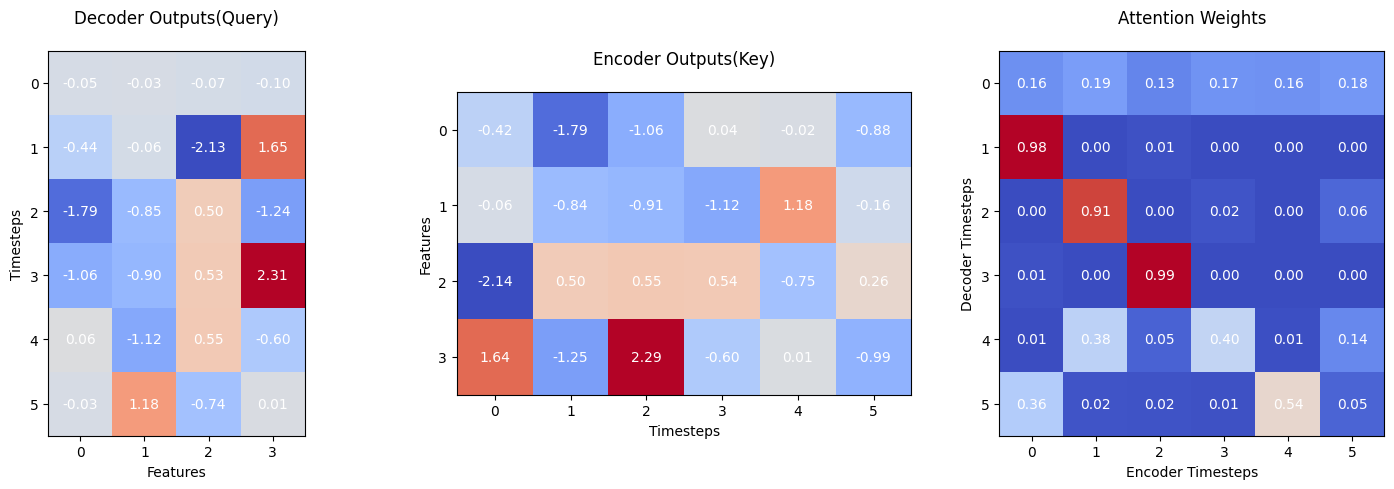

In [19]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], decoder_outputs, 'Decoder Outputs(Query)',  'Features', 'Timesteps')
plot_matrix(axes[1], encoder_outputs.T, 'Encoder Outputs(Key)', 'Timesteps', 'Features')

plot_matrix(axes[2], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

`attention_weights`와 `encoder_outputs` 간의 매트릭스 곱을 통하여 context vector가 만들어진다.

Context vector는 디코더가 출력 시퀀스를 생성할 때 인코더의 출력 중에서 가장 관련성이 높은 정보만을 요약하여 제공하는 역할을 한다.

입력 시퀀스의 모든 정보를 디코더에 직접 전달하는 대신, 현재 타임스텝에 가장 관련 있는 정보만을 요약하여 전달하여, 정보를 집약하고, 긴 시퀀스에서도 디코더가 필요한 정보를 쉽게 접근할 수 있게 한다.

아래 예제에서는 Enconder outputs(value)의 값이 context vectors에서 1 timestep 씩 뒤로 밀린 형태와 흡사함을 주목하라. 

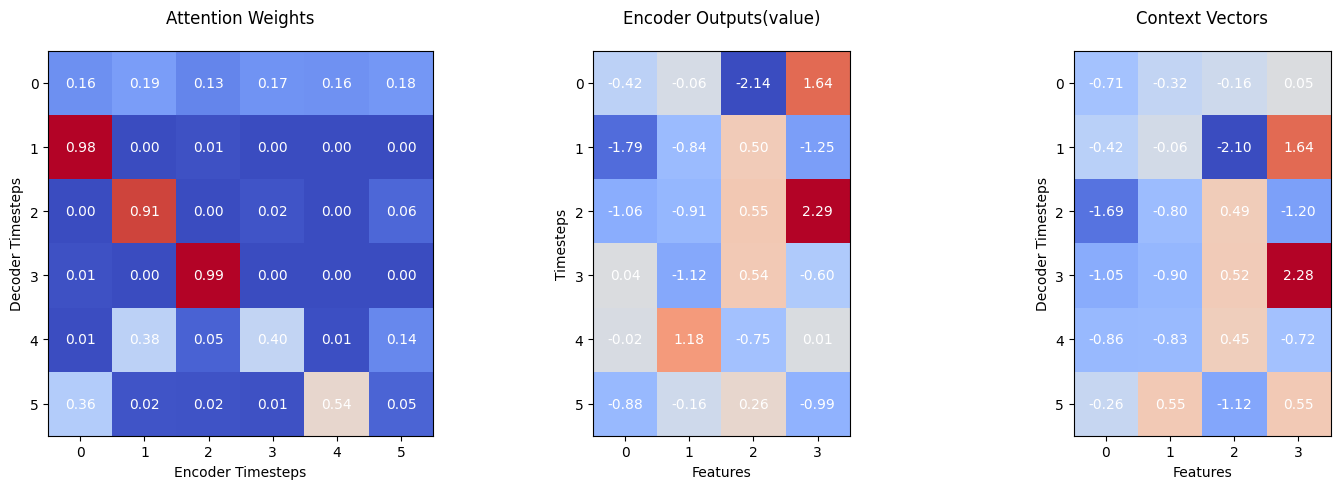

In [20]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plot_matrix(axes[1], encoder_outputs, 'Encoder Outputs(value)', 'Features', 'Timesteps')

plot_matrix(axes[2], context_vectors, 'Context Vectors', 'Features', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

최종적으로 `context_vectors`와 `decoder_outputs`을 concatenate하여 살펴보자.

이렇게 concatenate 된 데이터가 마지막 dense layer로 전달되어 time step별로 처리된다고 생각하면 된다.

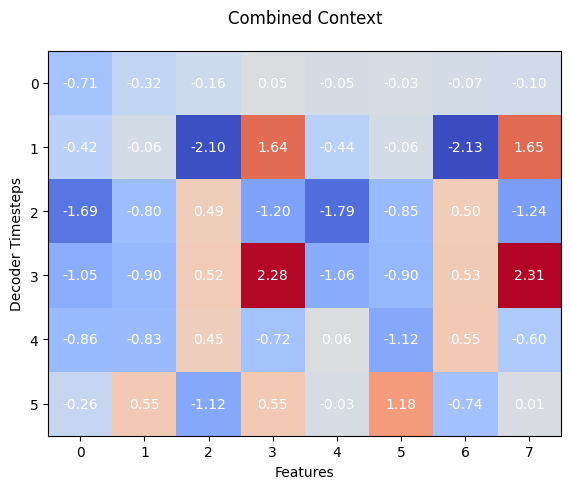

In [13]:
decoder_combined_context = np.concatenate([context_vectors, decoder_outputs], axis=-1)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# combined context: (batch, decoder_timesteps, 2 * latent_dim)
plot_matrix(axes, decoder_combined_context, 'Combined Context', 'Features', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

이번에는 디코더 출력값이 인코더 출력값을 거꾸로 뒤집은 시퀀스를 사용한 예제이다.

In [8]:
# 인코더 출력 (임의의 값)
encoder_outputs = np.random.normal(0, 1, size=(encoder_timesteps, latent_dim))
# 디코더 출력 
decoder_outputs = np.flip(encoder_outputs, axis=0) + 1 

# Attention 가중치 계산 (여기서는 단순한 내적)
attention_scores = np.dot(decoder_outputs, encoder_outputs.T)

# Softmax 적용하여 가중치 정규화
attention_weights = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=1, keepdims=True)

# Context 벡터 계산
context_vectors = np.dot(attention_weights, encoder_outputs)

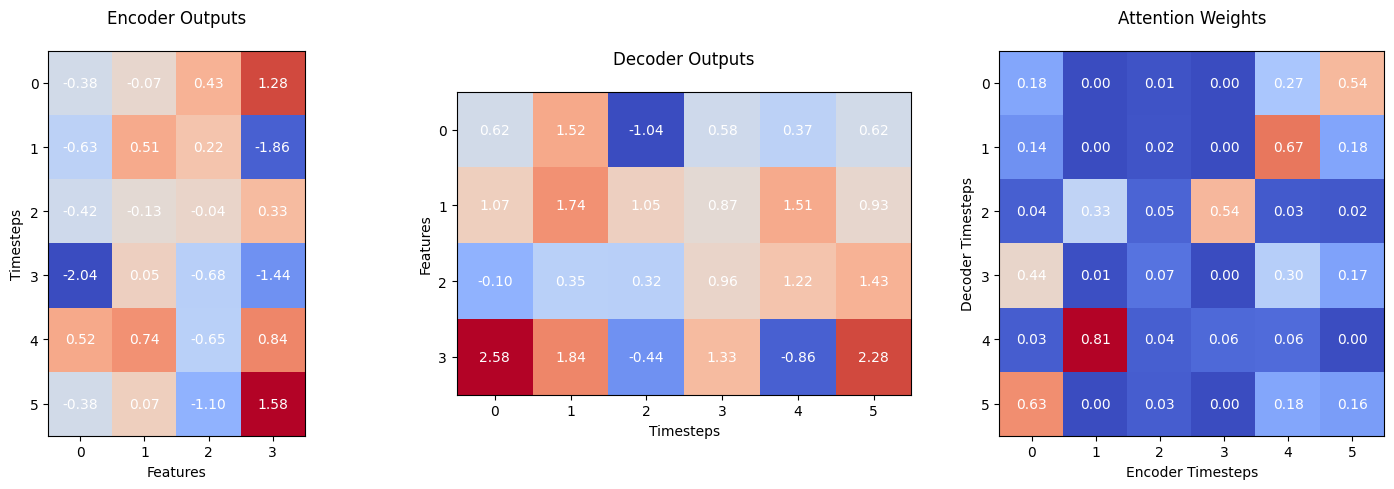

In [9]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], encoder_outputs, 'Encoder Outputs', 'Features', 'Timesteps')
plot_matrix(axes[1], decoder_outputs.T, 'Decoder Outputs', 'Timesteps', 'Features')

plot_matrix(axes[2], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

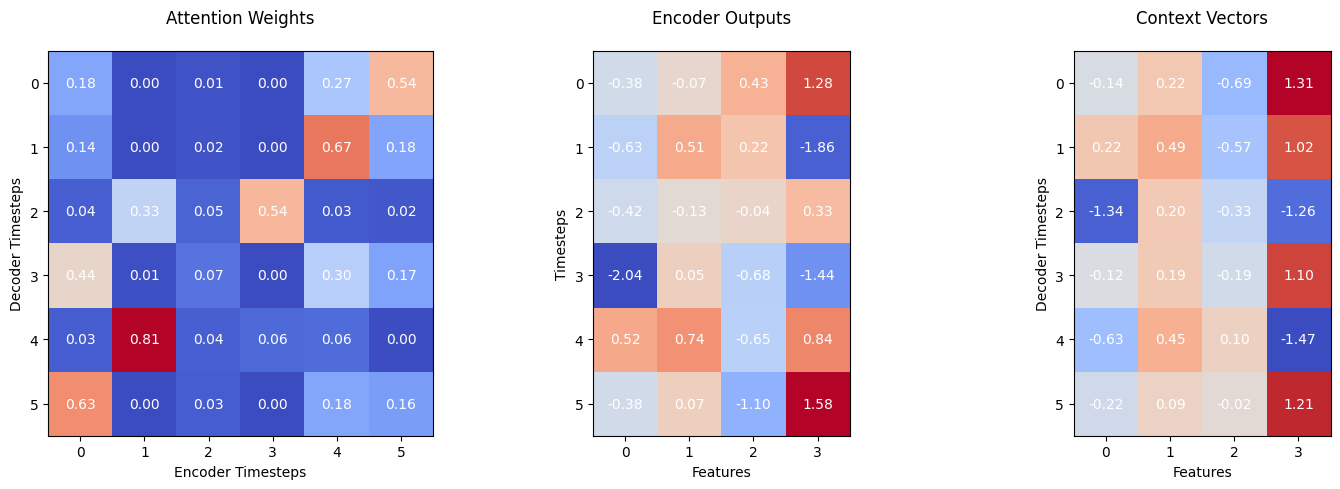

In [10]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plot_matrix(axes[1], encoder_outputs, 'Encoder Outputs', 'Features', 'Timesteps')

plot_matrix(axes[2], context_vectors, 'Context Vectors', 'Features', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

최종적으로 `context_vectors`와 `decoder_outputs`을 concatenate하여 살펴보자.

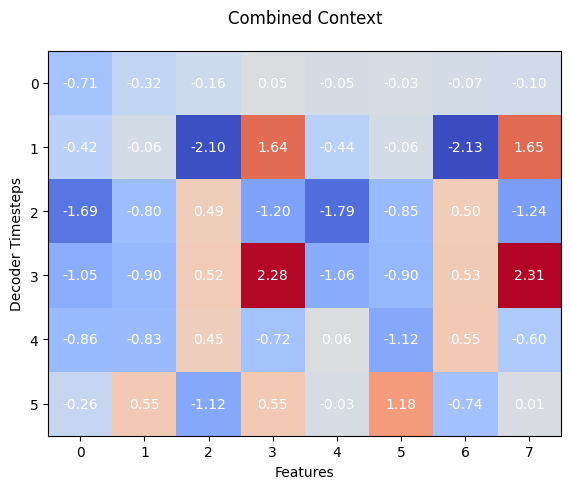

In [21]:
decoder_combined_context = np.concatenate([context_vectors, decoder_outputs], axis=-1)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# combined context: (batch, decoder_timesteps, 2 * latent_dim)
plot_matrix(axes, decoder_combined_context, 'Combined Context', 'Features', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

## Attention이 추가된 encoder-decoder 모형

이제 어텐션 메카니즘이 추가된 인코더-디코더 모형을 살펴보자.

먼저, enconder-decoder 모형은 이전 단원에서 했던 것과 비슷하게 구성하였다.

아래, 인코더의 출력 `encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)`을 보자.

여기서 `encoder_outputs`은  각 시점의 은닉 상태 벡터이다.

LSTM은 시퀀스를 한 시점씩 처리하며,

x₁ ─────▶ h₁, c₁  
x₂ ─────▶ h₂, c₂  
x₃ ─────▶ h₃, c₃  
x₄ ─────▶ h₄, c₄  
x₅ ─────▶ h₅, c₅  
x₆ ─────▶ h₆, c₆ 

와 같이 표현할 수 있고, 다음과 같다.

- `encoder_outputs = [h₁, h₂, h₃, h₄, h₅, h₆]`

- `state_h = h₆` (가장 마지막 은닉 상태)

- `state_c = c₆` (가장 마지막 셀 상태)

In [11]:
from keras.layers import Input, LSTM, Dense, Concatenate, Dot, Activation
from keras.models import Model
import numpy as np

# 입력 데이터 및 모델 파라미터 설정
timesteps = 6
input_dim = 3      # 3차원 입력, 출력 시퀀스
latent_dim = 50    # LSTM 유닛 수

# 인코더 정의
encoder_inputs = Input(shape=(timesteps, input_dim), name='encoder_input')
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# 디코더 정의 (훈련용)
decoder_inputs = Input(shape=(timesteps + 1, input_dim), name='decoder_input')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_outputs, encoder_outputs

(<KerasTensor: shape=(None, 7, 50) dtype=float32 (created by layer 'decoder_lstm')>,
 <KerasTensor: shape=(None, 6, 50) dtype=float32 (created by layer 'encoder_lstm')>)

#### Attention 구현

아래에서 [`Dot`](https://keras.io/api/layers/merging_layers/dot/)은 디코더 출력(decoder_outputs)과 인코더 출력(encoder_outputs) 간의 dot product를 계산한다.

- 위의 예제에서처럼 디코더 출력(decoder_outputs)은 query, 인코더 출력(encoder_outputs)은 key라고 표현한다.

- `Axes=[2, 2]` 여기서 두 텐서의 마지막 차원(axis 2)을 기준으로 dot product를 수행한다.

  - `latent_dim = 50` 길이의 두 벡터들 간의 dot product가 수행됨 <br><br>

- 이는 디코더의 각 타임스텝 출력과 인코더의 각 타임스텝 출력 간의 유사도를 계산하는 과정이다.

- 모든 디코더 시점(7개) × 모든 인코더 시점(6개) 조합으로 dot product을 진행하므로 `shape=(None, 7, 6)`이다.

   - `(batch_size, decoder_timesteps, encoder_timesteps)`

   - 각 배치 내에서 디코더의 각 타임스텝에 대해 인코더의 각 타임스텝과의 유사도 점수

In [12]:
attention_scores = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_scores

<KerasTensor: shape=(None, 7, 6) dtype=float32 (created by layer 'dot')>

Softmax Activation: dot product를 통해 얻은 유사도 점수는 softmax 활성화 함수를 통해 정규화 된다.

- 이 과정은 각 디코더 타임스텝에 대해 인코더 타임스텝의 중요도를 0과 1사이의 확률로 변환한다.

- 결과: 각 디코더 타임스텝에서 인코더 타임스텝 중 어디에 집중해야 하는지를 알려주는 가중치(Attention Weights)를 얻게 된다.

- 이 예제에서는 $7\times 6$ 크기의 행렬을 얻게 된다.

In [13]:
attention_weights = Activation('softmax', name='attention')(attention_scores)
attention_weights

<KerasTensor: shape=(None, 7, 6) dtype=float32 (created by layer 'attention')>

가중치 행렬 `attention_weights`와 `encoder_outputs`의 곱을 취하여 context 벡터로 이루어진 행렬을 생성한다.

- $7\times 6$ 행렬과 $6 \times 50$ 행렬의 곱이므로 $7 \times 50$ 행렬을 얻는다.

- `attention` 행렬에 `encoder_outputs`을 value로 취하여 곱을 취하는 과정.

- 이를 `Dot`을 이용하여 표현하면 아래 코드와 같다.  
  - 원래의 encoder output에 시퀀스의 어디가 중요한지가 반영된 버전이라 하겠다. <br><br>
 
- `context`의 shape의 timestep은 `decoder_outputs`의 timestep과 동일한 7임을 주목하라.

In [14]:
context = Dot(axes=[2, 1])([attention_weights, encoder_outputs])
context

<KerasTensor: shape=(None, 7, 50) dtype=float32 (created by layer 'dot_1')>

`context`와 `decoder_outputs`를 연결하여 다음 레이어로 전달할 것이다.

- `Concatenate(axis=-1, name='decoder_combined_context')([context, decoder_outputs])`

`context`에는 `decoder_outputs`를 최종 예측값으로 변환하는데 도움이 되는 요소가 담겨 있음.

`decoder_outputs`: 현재 시점의 디코더 LSTM 출력으로, 이전 상태와 현재 입력을 반영한 예측 계산을 위한 중간 과정 값 

- `decoder_output[0, 0, :]`를 이용하여 최종 결과를 계산할 때 도움이 되는 요소는 `context[0, 0, :]`에 요약되어 있다.
- `decoder_output[0, t, :]`를 이용하여 최종 결과를 계산할 때 도움이 되는 요소는 `context[0, t, :]`에 요약되어 있다.

In [15]:
decoder_combined_context = Concatenate(axis=-1, name='decoder_combined_context')([context, decoder_outputs])
decoder_combined_context

<KerasTensor: shape=(None, 7, 100) dtype=float32 (created by layer 'decoder_combined_context')>

In [16]:
decoder_dense = Dense(input_dim, activation='linear', name='decoder_output')
decoder_outputs = decoder_dense(decoder_combined_context)

# 모델 구성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


이 모델의 데이터 흐름은 다음과 같다.

```
encoder_input → [Encoder LSTM] → encoder_outputs, state_h, state_c
                                     ↓  
decoder_input → [Decoder LSTM] (uses state_h, state_c) → decoder_outputs
                                     ↓
    [Dot Product] (decoder_outputs, encoder_ouputs) → attention scores
                                     ↓
                     [Softmax] → attention weights
                                     ↓
    [Dot Product (Attention)] (attention_weights, encoder_outputs) → context
                                     ↓  
    [Concatenate] ([context, decoder_outputs]) → [Dense] → final_output
```

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 6, 3)]               0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 7, 3)]               0         []                            
                                                                                                  
 encoder_lstm (LSTM)         [(None, 6, 50),              10800     ['encoder_input[0][0]']       
                              (None, 50),                                                         
                              (None, 50)]                                                         
                                                                                              

위의 모델 요약에서 볼 수 있듯이, Attention 메커니즘은 여러 개의 Dot Product 연산으로 구성되며, 자체적으로 훈련 가능한 파라미터를 포함하지 않는다. 

그러나 Attention이 적용된 Context 벡터는 LSTM이나 Dense 레이어 등과 함께 사용되므로, 전체 모델 학습 과정에서는 간접적으로 학습이 이루어진다.

- 즉, 모델은 최적의 Attention 가중치가 생성되도록 인코더와 디코더의 출력을 학습한다.

- 컨텍스트 벡터는 인코더 출력과 Attention 가중치의 가중합이므로, 좋은 Attention 분포를 얻기 위해 인코더의 출력 표현이 정교하게 학습된다.

### 훈련

이전에 했던 예제와 비슷하게 `target_sequences`는 `input_sequences`를 시간 축에 대해 뒤집은 후 1을 더해 생성하였다.

`input_sequences`의 shape은 다음과 같다.

- `(num_samples, timesteps = 6, input_dim = 3)`

In [18]:
num_samples = 10000
input_sequences = np.random.uniform(0, 100, size=(num_samples, timesteps, input_dim))

# 데이터 전처리
input_sequences = input_sequences.astype(np.float32)
target_sequences = np.flip(input_sequences, axis=1) + 1

print(input_sequences[0,:,:])
print(target_sequences[0,:,:])

[[21.13435   57.28273   46.96578  ]
 [40.87917   10.492425   1.5226688]
 [97.88756   92.72824   38.07825  ]
 [63.97203   36.36669   90.39661  ]
 [49.37783   73.96465    1.5077583]
 [ 5.2651467 26.987593  11.937582 ]]
[[ 6.2651467 27.987593  12.937582 ]
 [50.37783   74.96465    2.5077581]
 [64.97203   37.36669   91.39661  ]
 [98.88756   93.72824   39.07825  ]
 [41.87917   11.492425   2.5226688]
 [22.13435   58.28273   47.96578  ]]


`start_token`과 `end_token`을 설정하여 디코더에 활용한다.

여기서도 디코더가 이전 시점의 실제 정답을 입력으로 받는 방식인 Teacher forcing 방법을 훈련에 사용할 것이다.

- `decoder_input_data_with_start_token` → 디코더 입력 ($Y_{t-1}$)

- `output_data_with_end_token` → 디코더 출력 목표 ($Y_t$)


In [19]:
start_token = np.zeros((target_sequences.shape[0], 1, target_sequences.shape[2]))
decoder_input_data_with_start_token = np.concatenate([start_token, target_sequences[:, :, :]], axis=1)

end_token = np.zeros((target_sequences.shape[0], 1, target_sequences.shape[2]))
output_data_with_end_token = np.concatenate([target_sequences, end_token], axis=1)

print("Encoder input data  : \n",  np.squeeze(input_sequences[0, :, :]))
print("Decoder input data  : \n", np.squeeze(decoder_input_data_with_start_token[0, :, :]))
print("Target data         : \n", np.squeeze(output_data_with_end_token[0, :, :]))

Encoder input data  : 
 [[21.13435   57.28273   46.96578  ]
 [40.87917   10.492425   1.5226688]
 [97.88756   92.72824   38.07825  ]
 [63.97203   36.36669   90.39661  ]
 [49.37783   73.96465    1.5077583]
 [ 5.2651467 26.987593  11.937582 ]]
Decoder input data  : 
 [[ 0.          0.          0.        ]
 [ 6.26514673 27.9875927  12.93758202]
 [50.37783051 74.96465302  2.50775814]
 [64.97203064 37.36669159 91.39660645]
 [98.88755798 93.72824097 39.07825089]
 [41.87916946 11.49242496  2.52266884]
 [22.13434982 58.2827301  47.96577835]]
Target data         : 
 [[ 6.26514673 27.9875927  12.93758202]
 [50.37783051 74.96465302  2.50775814]
 [64.97203064 37.36669159 91.39660645]
 [98.88755798 93.72824097 39.07825089]
 [41.87916946 11.49242496  2.52266884]
 [22.13434982 58.2827301  47.96577835]
 [ 0.          0.          0.        ]]


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

훈련에 사용되는 값 정리

- `input_sequences` : 인코더 input
- `decoder_input_data_with_start_token` : 디코더 input
- `output_data_with_end_token` : 디코더 output을 훈련하기 위한 타겟으로 정답 시퀀스

In [22]:
model.fit([input_sequences, decoder_input_data_with_start_token], output_data_with_end_token, epochs=50, batch_size=32)

Epoch 1/50
313/313 [==============================] - 8s 9ms/step - loss: 1815.3406
Epoch 2/50
313/313 [==============================] - 3s 9ms/step - loss: 1055.0088
Epoch 3/50
313/313 [==============================] - 3s 9ms/step - loss: 889.8114
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 739.8765
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 675.3611
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 610.1663
Epoch 7/50
313/313 [==============================] - 3s 9ms/step - loss: 560.1271
Epoch 8/50
313/313 [==============================] - 3s 10ms/step - loss: 531.1191
Epoch 9/50
313/313 [==============================] - 3s 9ms/step - loss: 510.4366
Epoch 10/50
313/313 [==============================] - 3s 9ms/step - loss: 492.4120
Epoch 11/50
313/313 [==============================] - 3s 9ms/step - loss: 474.3990
Epoch 12/50
313/313 [==============================] - 3s 10ms/step - loss: 447.8

### 예측

이전 예제와 같이 예측 단계에서는 step-by-step으로 각 step 별로 진행.

예측을 위해 인코더 모델과 디코더 모델을 생성한다.

인코더 모델은 훈련에 사용한 인코더 부분을 그대로 가져온다.

디코더 모델은 한 번에 하나의 값을 받도록 디코더 인풋만 재설정하고, LSTM과 Dense layer는 훈련된 층을 그대로 이용한다.

Attention 파트도 다시 정의하여 사용

- 예측 단계에서는 `decoder_outputs.shape = (batch_size, 1, latent_dim)`
- 훈련 단계에서는 `decoder_outputs.shape = (batch, timesteps+1, latent_dim)`

In [23]:
# 예측을 위한 모델 설정
# 인코더는 기존의 모델 그대로 이용
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# 디코더의 입력이 한 번에 하나의 값을 받음
decoder_single_input = Input(shape=(1, input_dim), name="previous_prediction")
decoder_state_input_h = Input(shape=(latent_dim,), name="hidden_status")
decoder_state_input_c = Input(shape=(latent_dim,), name="cell_status")
encoder_output_input = Input(shape=(timesteps, latent_dim), name="encoder_output")

# 훈련된 decoder_lstm을 이용
decoder_outputs, state_h, state_c = decoder_lstm(decoder_single_input, initial_state=[decoder_state_input_h, decoder_state_input_c])

attention_scores = Dot(axes=[2, 2], name="attention_scores")([decoder_outputs, encoder_output_input])
attention_weights = Activation('softmax', name="attention_weights")(attention_scores)
context = Dot(axes=[2, 1], name="context_vector")([attention_weights, encoder_output_input])
decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

# 훈련된 decoder_dense를 이용
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_states = [state_h, state_c]

decoder_model = Model(
    inputs=[decoder_single_input, encoder_output_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 previous_prediction (Input  [(None, 1, 3)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 hidden_status (InputLayer)  [(None, 50)]                 0         []                            
                                                                                                  
 cell_status (InputLayer)    [(None, 50)]                 0         []                            
                                                                                                  
 decoder_lstm (LSTM)         multiple                     10800     ['previous_prediction[0]

In [24]:
new_input_sequence = np.array([[[11., 21., 93.],
                                [19., 22., 34.],
                                [13., 33., 25.],
                                [32., 14., 26.],
                                [56., 75., 47.],
                                [26., 76., 58.]]])

encoder_output, h, c = encoder_model.predict(new_input_sequence)

# 디코더의 초기 입력 (시작 토큰)
target_seq = np.zeros((1, 1, input_dim))
target_seq[0, 0, :] = 0.0

predicted_sequence = []

for t in range(timesteps):
    output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, h, c])

    print("Predicted value in this step: ", output_tokens[0, 0, :], "based on", target_seq[0,0,:])
    # 가장 최근의 디코더 출력을 저장
    predicted_sequence.append(output_tokens[0, 0, :])

    # 다음 타임스텝을 위한 디코더 입력 준비 (현재 출력 사용)
    target_seq = np.zeros((1, 1, input_dim))
    target_seq[0, 0, :] = output_tokens[0, 0, :]

    # 갱신된 상태 사용
    h, c = [h, c]

predicted_sequence = np.array(predicted_sequence)

print("New_input_sequence:")
print(new_input_sequence)

print("Predicted sequence:")
print(predicted_sequence)

1/1 [==============================] - 1s 568ms/step
Predicted value in this step:  [25.600632 75.920296 58.724983] based on [0. 0. 0.]
1/1 [==============================] - 0s 38ms/step
Predicted value in this step:  [58.31751  79.487595 49.39612 ] based on [25.60063171 75.92029572 58.72498322]
1/1 [==============================] - 0s 35ms/step
Predicted value in this step:  [32.62639  15.804909 26.288412] based on [58.3175087  79.4875946  49.39611816]
1/1 [==============================] - 0s 39ms/step
Predicted value in this step:  [11.746767 33.440403 22.998875] based on [32.62638855 15.80490875 26.28841209]
1/1 [==============================] - 0s 39ms/step
Predicted value in this step:  [21.598974 24.770578 35.91328 ] based on [11.74676704 33.44040298 22.99887466]
1/1 [==============================] - 0s 39ms/step
Predicted value in this step:  [16.427004 23.922075 93.40314 ] based on [21.59897423 24.77057838 35.91328049]
New_input_sequence:
[[[11. 21. 93.]
  [19. 22. 34.]
  

이 예측 과정의 데이터 흐름은 다음과  같다.
```
test_input → [Trained Encoder LSTM] → state_h, state_c, encoder_outputs
                                        ↓  
start_token                             ↓
 → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs                                      
 → [Attention] (decoder_outputs, encoder_ouputs) → context → [Concatenate] ([context, decoder_outputs]) → [Trained Dense] 
    → next_value                        ↓       
       → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs                                      
       → [Attention] (decoder_outputs, encoder_ouputs) → context → [Concatenate] ([context, decoder_outputs]) → [Trained Dense]
          → next_value 
                                  (Repeat)
```

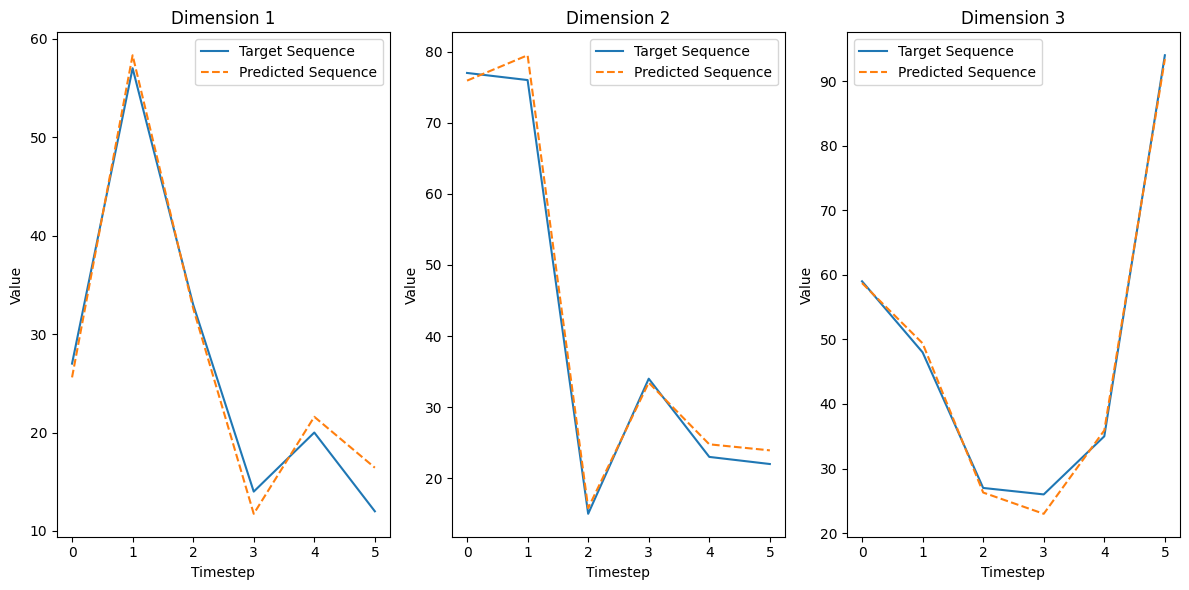

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 입력 시퀀스를 시간 축으로 뒤집고 1을 더함
reversed_input_sequence = np.flip(new_input_sequence, axis=1) + 1

# 입력 시퀀스와 예측 시퀀스를 시각화
def plot_sequences(modified_input_sequence, predicted_sequence):
    timesteps = modified_input_sequence.shape[1]
    input_dim = modified_input_sequence.shape[2]
    
    plt.figure(figsize=(12, 6))
    
    for dim in range(input_dim):
        plt.subplot(1, input_dim, dim + 1)
        plt.plot(range(timesteps), modified_input_sequence[0, :, dim], label='Target Sequence')
        plt.plot(range(timesteps), predicted_sequence[:, dim], label='Predicted Sequence', linestyle='--')
        plt.title(f'Dimension {dim + 1}')
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
plot_sequences(reversed_input_sequence, predicted_sequence)


## 보다 일반적인 attention mechanism

나중에 살펴볼 Transformer 등 일반적인 어텐션 모형에서는 쿼리, 키, 값의 세 가지 벡터들을 이용하여 attention 메커니즘을 정의한다.

여기에 훈련 가능한 가중치 행렬 $W$들을 이용하여 쿼리, 키, 값을 생성하는 방법을 살펴본다.

- 쿼리(Q)
  * 디코더의 출력 벡터에 학습 가능한 가중치 행렬 $W_q$를 곱하여 쿼리를 생성한다.  
  * 디코더는 현재 어떤 정보를 참조할지 결정하기 위해 자신의 상태(출력)를 기준으로 삼는다. <br><br>  
 
    
- 키(K)와 값(V):
  - 인코더의 출력에 각각 행렬 `W_k`와 `W_v`를 곱하여 키와 값을 생성한다.
  - Key는 입력 시퀀스의 각 위치가 담고 있는 정보의 "주소" 역할을 하며,
  - Value는 해당 위치의 실제 "내용"이다.
  - 인코더의 출력은 입력 시퀀스의 각 부분을 나타내며, 디코더가 이들 중 어떤 것이 필요한지를 판단할 수 있도록 한다.

본격적으로 네트워크를 구성하기 전에, `numpy`를 이용한 시각화 예제를 살펴본다.
    
아래 예제에서는 가중치 행렬 `W`들을 간단히 정의하였지만, 실제 뉴럴 네트워크 모형에서는 훈련 가능한 파라미터들로 구성된다.

한편, 아래 코드에서 `W`들의 shape은 `(latent_dim, latent_dim)`로 하여, 생성된 쿼리/키, 값의 차원을 `latent_dim`로 동일하게 하였다.

- 만약, `W`들의 열의 개수를 조정하여, 생성되는 쿼리/키, 값의 차원을 조절할 수 있다. 일반적인 상황에 대해서는 다음의 표를 참고하라.


| 항목                   | shape            | 설명                 |
| -------------------- | ---------------- | ------------------ |
| `W_q`                | `(d_model, d_k)` | 입력을 쿼리로 변환하는 가중치   |
| `W_k`                | `(d_model, d_k)` | 입력을 키로 변환하는 가중치    |
| `W_v`                | `(d_model, d_v)` | 입력을 값으로 변환하는 가중치   |
| `Q`                  | `(T, d\_k)`       | 디코더 또는 입력에서 생성된 쿼리 |
| `K`                  | `(T, d\_k)`        | 인코더 출력에서 생성된 키     |
| `V`                  | `(T, d\_v)`        | 인코더 출력에서 생성된 값     |
| `Attention(Q, K, V)` | `(T, d\_v)`       | 최종 컨텍스트 벡터         |

- `d_model` : 모형의 dimenion, 이 예제에서는 `encoder_output` dimension인 `latent_dim`을 의미
- `T` : 시퀀스 길이
- `d_k` : 쿼리와 키의 차원, `d_v` : value의 차원


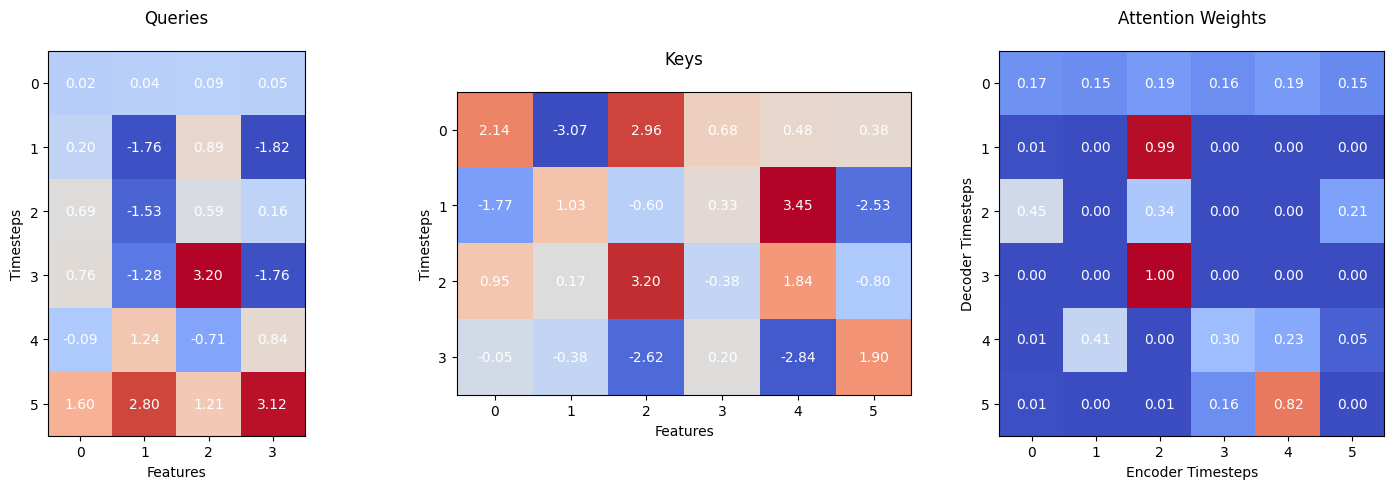

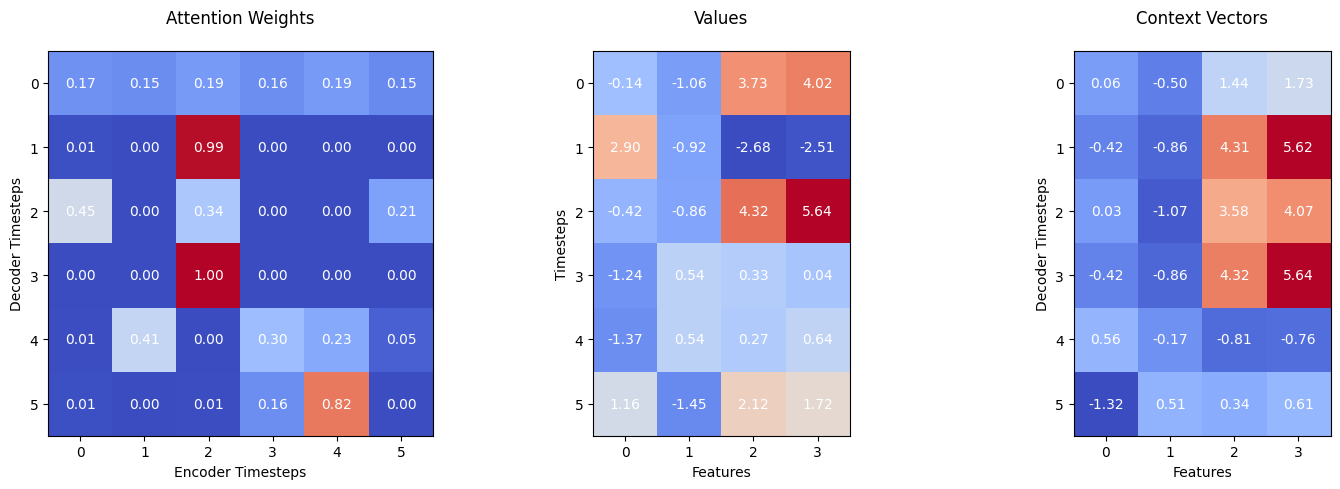

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 설정
encoder_timesteps = 6
decoder_timesteps = 6
latent_dim = 4

# 인코더 출력 (임의의 값)
encoder_outputs = np.random.normal(0, 1, size=(encoder_timesteps, latent_dim))

# 디코더 출력
decoder_outputs = np.roll(encoder_outputs, shift=1, axis=0)
decoder_outputs[0] = np.random.normal(0, 0.1, latent_dim)
decoder_outputs = decoder_outputs + np.random.normal(0, 0.01, decoder_outputs.shape)

# 가상의 가중치 행렬 생성 (랜덤하게 생성함)
W_q = np.random.normal(0, 1, (latent_dim, latent_dim))
W_k = np.random.normal(0, 1, (latent_dim, latent_dim))
W_v = np.random.normal(0, 1, (latent_dim, latent_dim))

# 쿼리, 키, 값 생성
queries = np.dot(decoder_outputs, W_q)
keys = np.dot(encoder_outputs, W_k)
values = np.dot(encoder_outputs, W_v)

# 어텐션 가중치 계산 (여기서는 단순한 내적)
attention_scores = np.dot(queries, keys.T)

# Softmax 적용하여 가중치 정규화
attention_weights = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=1, keepdims=True)

# Context 벡터 계산
context_vectors = np.dot(attention_weights, values)


# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], queries, 'Queries', 'Features', 'Timesteps')

plot_matrix(axes[1], keys.T, 'Keys', 'Features', 'Timesteps')

plot_matrix(axes[2], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plt.tight_layout()
plt.show()

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_matrix(axes[0], attention_weights, 'Attention Weights', 'Encoder Timesteps', 'Decoder Timesteps')

plot_matrix(axes[1], values, 'Values', 'Features', 'Timesteps')

plot_matrix(axes[2], context_vectors, 'Context Vectors', 'Features', 'Decoder Timesteps')

plt.tight_layout()
plt.show()


뉴럴 네트워크를 이용하여 인코더 디코더 모델이 구현하여 보자.

쿼리, 키, 값을 생성하기 위한 가중치 행렬을 `Dense`로 생성하는 부분을 제외하고는 앞서 구현한 인코더-디코더 예제와 동일하다.

`W` 출력들의 dimension은 `latent_dim`로 하였으나, 이전에 설명한대로 조정 가능하다.

```
# 쿼리, 키, 값 가중치 생성
W_q = Dense(latent_dim, name='W_q')
W_k = Dense(latent_dim, name='W_k')
W_v = Dense(latent_dim, name='W_v')

# 쿼리, 키, 값 계산
queries = W_q(decoder_outputs)
keys = W_k(encoder_outputs)
values = W_v(encoder_outputs)
```

In [27]:

from keras.layers import Input, LSTM, Dense, Concatenate, Dot, Activation
from keras.models import Model

# 입력 데이터 및 모델 파라미터 설정
timesteps = 6
input_dim = 3
latent_dim = 50


# 인코더 정의
encoder_inputs = Input(shape=(timesteps, input_dim), name='encoder_input')
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# 디코더 정의
decoder_inputs = Input(shape=(timesteps + 1, input_dim), name='decoder_input')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# 쿼리, 키, 값 가중치 생성
W_q = Dense(latent_dim, name='W_q')
W_k = Dense(latent_dim, name='W_k')
W_v = Dense(latent_dim, name='W_v')

# 쿼리, 키, 값 계산
queries = W_q(decoder_outputs)
keys = W_k(encoder_outputs)
values = W_v(encoder_outputs)

# 어텐션 스코어 계산
attention_scores = Dot(axes=[2, 2])([queries, keys])

# Softmax 적용
attention_weights = Activation('softmax')(attention_scores)

# 컨텍스트 벡터 계산
context_vectors = Dot(axes=[2, 1])([attention_weights, values])

# 컨텍스트 벡터와 디코더 출력 결합
decoder_combined_context = Concatenate(axis=-1)([context_vectors, decoder_outputs])

# 출력층 정의
decoder_dense = Dense(input_dim, activation='linear', name='decoder_output')
decoder_outputs = decoder_dense(decoder_combined_context)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 요약 출력
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 6, 3)]               0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 7, 3)]               0         []                            
                                                                                                  
 encoder_lstm (LSTM)         [(None, 6, 50),              10800     ['encoder_input[0][0]']       
                              (None, 50),                                                         
                              (None, 50)]                                                         
                                                                                            

모델에서 데이터의 흐름은 다음과 같다.

```
encoder_input → [Encoder LSTM] → encoder_outputs, state_h, state_c
                                      ↓  
decoder_input → [Decoder LSTM] (uses state_h, state_c) → decoder_outputs
                                      ↓  
                decoder_outputs → [Dense (W_q)] → queries
                encoder_outputs → [Dense (W_k)] → keys
                encoder_outputs → [Dense (W_v)] → values
                                      ↓  
          [Dot Product] (queries, keys) → attention_scores
                                      ↓  
                  [Softmax] → attention_weights
                                      ↓  
       [Dot Product] (attention_weights, values) → context_vectors
                                      ↓  
         [Concatenate] ([context_vectors, decoder_outputs])  → [Dense] → final_output
```

In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model.fit([input_sequences, decoder_input_data_with_start_token], output_data_with_end_token, epochs=50, batch_size=32)

Epoch 1/50
313/313 [==============================] - 9s 10ms/step - loss: 1278.5333
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 680.1199
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 516.5289
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 301.6712
Epoch 5/50
313/313 [==============================] - 3s 11ms/step - loss: 158.3327
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 96.6267
Epoch 7/50
313/313 [==============================] - 3s 10ms/step - loss: 63.7507
Epoch 8/50
313/313 [==============================] - 3s 10ms/step - loss: 44.2727
Epoch 9/50
313/313 [==============================] - 3s 10ms/step - loss: 31.5683
Epoch 10/50
313/313 [==============================] - 3s 11ms/step - loss: 23.9858
Epoch 11/50
313/313 [==============================] - 3s 10ms/step - loss: 18.4660
Epoch 12/50
313/313 [==============================] - 3s 10ms/step - loss: 15.

### 예측

예측 파트 또한 이전에 구현한 인코더-디코더 모형과 거의 동일하다.

In [32]:
# 예측을 위한 모델 설정
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 6, 3)]            0         
                                                                 
 encoder_lstm (LSTM)         [(None, 6, 50),           10800     
                              (None, 50),                        
                              (None, 50)]                        
                                                                 
Total params: 10800 (42.19 KB)
Trainable params: 10800 (42.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# 디코더의 입력이 한 번에 하나의 값을 받음
decoder_single_input = Input(shape=(1, input_dim), name="previous_prediction")
decoder_state_input_h = Input(shape=(latent_dim,), name="hidden_status")
decoder_state_input_c = Input(shape=(latent_dim,), name="cell_status")
encoder_output_input = Input(shape=(timesteps, latent_dim), name="encoder_output")

decoder_outputs, state_h, state_c = decoder_lstm(decoder_single_input, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 쿼리, 키, 값 계산
queries = W_q(decoder_outputs)
keys = W_k(encoder_output_input)
values = W_v(encoder_output_input)

# 컨텍스트 벡터 계산
attention_scores = Dot(axes=[2, 2])([queries, keys])
attention_weights = Activation('softmax')(attention_scores)
context_vectors = Dot(axes=[2, 1])([attention_weights, values])

# 컨텍스트 벡터와 디코더 출력 결합
decoder_combined_context = Concatenate(axis=-1)([context_vectors, decoder_outputs])

# 출력층 정의
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_states = [state_h, state_c]

decoder_model = Model(
    inputs=[decoder_single_input, encoder_output_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs] + decoder_states)

decoder_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 previous_prediction (Input  [(None, 1, 3)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 hidden_status (InputLayer)  [(None, 50)]                 0         []                            
                                                                                                  
 cell_status (InputLayer)    [(None, 50)]                 0         []                            
                                                                                                  
 decoder_lstm (LSTM)         multiple                     10800     ['previous_prediction[0]

In [36]:

# 새로운 입력 시퀀스
new_input_sequence = np.array([[[11., 21., 93.],
                                [19., 22., 34.],
                                [13., 33., 25.],
                                [32., 14., 26.],
                                [56., 75., 47.],
                                [26., 76., 58.]]])

encoder_output, h, c = encoder_model.predict(new_input_sequence)

# 디코더의 초기 입력 (시작 토큰)
target_seq = np.zeros((1, 1, input_dim))
target_seq[0, 0, :] = 0.0

predicted_sequence = []

for t in range(timesteps):
    output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, h, c])

    print("Predicted value in this step: ", output_tokens[0, 0, :], "based on", target_seq[0,0,:])
    # 가장 최근의 디코더 출력을 저장
    predicted_sequence.append(output_tokens[0, 0, :])

    # 다음 타임스텝을 위한 디코더 입력 준비 (현재 출력 사용)
    target_seq = np.zeros((1, 1, input_dim))
    target_seq[0, 0, :] = output_tokens[0, 0, :]

predicted_sequence = np.array(predicted_sequence)

print("New_input_sequence:")
print(new_input_sequence)

print("Predicted sequence:")
print(predicted_sequence)

1/1 [==============================] - 0s 35ms/step
Predicted value in this step:  [27.903269 76.40925  58.159843] based on [0. 0. 0.]
1/1 [==============================] - 0s 35ms/step
Predicted value in this step:  [56.628407 75.81286  46.77134 ] based on [27.90326881 76.40924835 58.15984344]
1/1 [==============================] - 0s 42ms/step
Predicted value in this step:  [32.703587 15.078582 27.137465] based on [56.62840652 75.81285858 46.77133942]
1/1 [==============================] - 0s 39ms/step
Predicted value in this step:  [14.888539 34.055984 25.360874] based on [32.70358658 15.07858181 27.13746452]
1/1 [==============================] - 0s 38ms/step
Predicted value in this step:  [21.364017 23.796886 34.273594] based on [14.88853931 34.0559845  25.36087418]
1/1 [==============================] - 0s 38ms/step
Predicted value in this step:  [13.327215 22.761702 92.39096 ] based on [21.36401749 23.79688644 34.2735939 ]
New_input_sequence:
[[[11. 21. 93.]
  [19. 22. 34.]
  [

이 예측 과정의 데이터 흐름은 다음과  같다.
```
test_input → [Trained Encoder LSTM] → state_h, state_c, encoder_outputs
                                        ↓  
start_token                             ↓
 → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs
 → [Denses (W_q, W_k, W_v)] (encoder_outputs, decoder_outputs) → queries, keys, values                                      
 → [Attention] (queries, keys, values) → context → [Concatenate] ([context, decoder_outputs]) → [Trained Dense] 
    → next_value                        ↓
       → [Trained Decoder LSTM] (state_h, state_c) → state_h, state_c, decoder_outputs
       → [Denses (W_q, W_k, W_v)] (encoder_outputs, decoder_outputs) → queries, keys, values                                        
       → [Attention] (decoder_outputs, encoder_ouputs) → context → [Concatenate] ([context, decoder_outputs]) → [Trained Dense]
          → next_value 
                                  (Repeat)
```

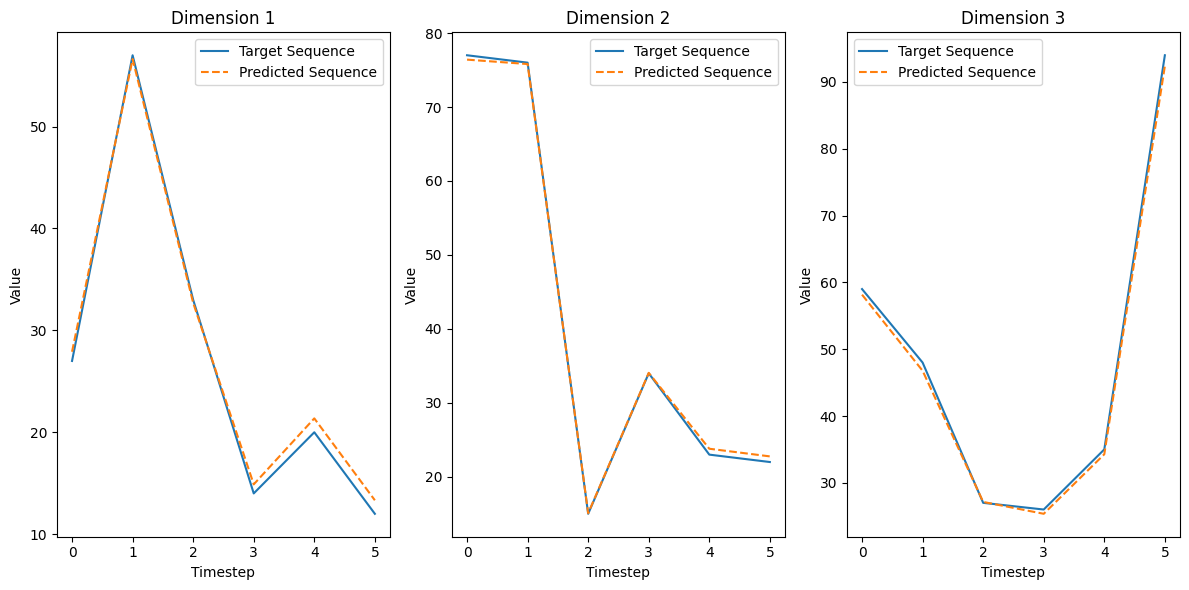

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 입력 시퀀스를 시간 축으로 뒤집고 1을 더함
reversed_input_sequence = np.flip(new_input_sequence, axis=1) + 1

# 입력 시퀀스와 예측 시퀀스를 시각화
def plot_sequences(modified_input_sequence, predicted_sequence):
    timesteps = modified_input_sequence.shape[1]
    input_dim = modified_input_sequence.shape[2]
    
    plt.figure(figsize=(12, 6))
    
    for dim in range(input_dim):
        plt.subplot(1, input_dim, dim + 1)
        plt.plot(range(timesteps), modified_input_sequence[0, :, dim], label='Target Sequence')
        plt.plot(range(timesteps), predicted_sequence[:, dim], label='Predicted Sequence', linestyle='--')
        plt.title(f'Dimension {dim + 1}')
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
plot_sequences(reversed_input_sequence, predicted_sequence)
